In [17]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import requests
import re
import seaborn as sns
from bs4 import BeautifulSoup
from datetime import datetime

In [18]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

tvUrl = 'https://www.imdb.com/title/tt0472954/episodes/?season=';

In [19]:
# get season 1 page for initial show name + season number collection
response = requests.get(tvUrl + "1", headers=headers)
soup = BeautifulSoup(response.text, 'html.parser')

# all <li> elements with data-testid names of tab-season-entry will be put into a list
# the list will be used to make a range with stripped whitespace, which will be used in an upcoming for loop to iterate through season and episodes
# 1 added to each entry in range since for loop stops at 1 below the max (e.g. range(1,9) will iterate seasons 1 to 8)
seasontabs = soup.find_all('a', {"data-testid" : 'tab-season-entry'})
seasons = []
for tab in seasontabs:
    try:
        season_number = int(tab.text.strip())
        seasons.append(season_number)
    except ValueError:
        print(f"Skipping non-integer season tab: {tab.text.strip()}")

# Now seasons will only contain integer values
seasons = range(1, max(seasons) + 1)

# the show name is located in an h2 element, with the class 'sc-a885edd8-9 dcErWY'. strip the whitespace
show_name = soup.find('h2', class_='sc-a885edd8-9 dcErWY').text.strip()
print(seasons)
print(show_name)

Skipping non-integer season tab: Unknown
range(1, 19)
It's Always Sunny in Philadelphia


In [20]:
def text_to_num(text):
    
    dic = {'K': 1000, 'M': 1000000}

    if text[-1] in dic:
        num, mag = text[:-1], text[-1]
        return int(float(num) * dic[mag])
    else:
        return float(text)

In [21]:
epnum = re.compile(r'S[0-9]+\.E([0-9]+)')
ratingmatch = re.compile(r'(\d+(?:\.\d+)?)')
votesmatch = re.compile(r'\(([^)]*)\)')

show = []
cumulative_episode_number = 0

for season in seasons:

    # set response using headers from before
    response = requests.get(tvUrl + str(season), headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    # find all divs with class kyIRYf, this is the episode info we need
    episodes = soup.find_all('div', class_='sc-f2169d65-1 bomFtL')
    
    # for every episode in episodes array we can extract each title
    for episode in episodes:
        # title found in div of class ipfc-title__text, strip to get rid of leading/trailing whitespace
        # this element includes both episode number and title- will be further separated
        title = episode.find('div', class_='ipc-title__text').text.strip()
        # take episode number from title string using regex, convert to int
        episode_number = int(epnum.sub('\\1', title.split(' ∙ ')[0]))
        # update cumulative episode number
        cumulative_episode_number += 1
        # grab title from string, split by dot
        title = title.split(' ∙ ')[1]
        # rating is located in the span of class ipc-rating-star, strip this like the title
        # try / except for future pending season/episode entries with no data: we don't want this and it'll just cause an error.
        try:
            rating = episode.find('span', class_='ipc-rating-star').text.strip()
        except AttributeError:
            break
        # find rating value using regex, first group found, convert to float
        rating_value = re.search(ratingmatch, rating).group(1)
        if '.' in rating_value:
            rating_value = float(rating_value)
        else:
            rating_value = int(rating_value)
        # find vote count from rating string using regex, first group found, convert to num from text
        votes = text_to_num(re.search(votesmatch, rating).group(1))\
        # airdate located in span with class fyhHWhz- strip whitespace, format to proper date notation and convert to datetime
        air_date = datetime.strptime(episode.find('span', class_='sc-f2169d65-10 iZXnmI').text.strip(), r'%a, %b %d, %Y')
        # description located in div of class ipc-html-content-inner-div, strip whitespace from result
        description = episode.find('div', class_='ipc-html-content-inner-div').text.strip()

        # compile all final found and cleaned data into array, print and append to show (turn show into array of arrays)
        episode_data = [season, episode_number, cumulative_episode_number, title, air_date, rating_value, votes, description]
        print(episode_data)
        show.append(episode_data)

[1, 1, 1, 'The Gang Gets Racist', datetime.datetime(2005, 8, 4, 0, 0), 8.1, 5100, "The guys hire Dee's friend as a promoter for the bar and get more than they bargained for. Charlie seeks black friends to prove he isn't a racist."]
[1, 2, 2, 'Charlie Wants an Abortion', datetime.datetime(2005, 8, 11, 0, 0), 8.2, 4500, 'In this take on the abortion debate Dennis and Mac go to opposite sides of an abortion rally to pick up women while Charlie deals with an unruly kid he believes to be his son.']
[1, 3, 3, 'Underage Drinking: A National Concern', datetime.datetime(2005, 8, 16, 0, 0), 8.2, 4400, "The gang turns Paddy's into a safe haven for teens, but things get weird when they all get asked to the local high school prom."]
[1, 4, 4, 'Charlie Has Cancer', datetime.datetime(2005, 8, 23, 0, 0), 8.0, 4100, 'When Charlie confidentially confides that he has cancer, it leads to a series of instances of the guys manipulating women and one gorgeous transsexual (not a transvestite).']
[1, 5, 5, 'Gu

In [22]:

show = pd.DataFrame(show,columns=["season", "episode_number", "cumulative_episode_number", "title", "air_date", "rating_value", "votes", "description"])
show.head(20)

,season,episode_number,cumulative_episode_number,title,air_date,rating_value,votes,description
0,1,1,1,The Gang Gets Racist,2005-08-04,8.1,5100,The guys hire Dee's friend as a promoter for t...
1,1,2,2,Charlie Wants an Abortion,2005-08-11,8.2,4500,In this take on the abortion debate Dennis and...
2,1,3,3,Underage Drinking: A National Concern,2005-08-16,8.2,4400,The gang turns Paddy's into a safe haven for t...
3,1,4,4,Charlie Has Cancer,2005-08-23,8.0,4100,When Charlie confidentially confides that he h...
4,1,5,5,Gun Fever,2005-08-30,7.8,3900,"When Paddy's gets robbed, the gang decides to ..."
5,1,6,6,The Gang Finds a Dead Guy,2005-09-06,8.0,3800,A guy dies in Paddy's pub. Dennis and Mac use ...
6,1,7,7,Charlie Got Molested,2005-09-13,8.4,4100,The gang learns that Charlie's former elementa...
7,2,1,8,Charlie Gets Crippled,2006-06-29,8.5,4000,The gang discovers the perks of being handicap...
8,2,2,9,The Gang Goes Jihad,2006-06-29,8.6,4000,When half of Paddy's gets bought out by a busi...
9,2,3,10,Dennis and Dee Go on Welfare,2006-07-06,9.0,4800,Dennis and Dee quit their jobs and concoct a p...


Average:  8.362721893491125
Max:  9.8 , episode(s):  ['Charlie Work']
Min:  6.6 , episode(s):  ['The Gang Beats Boggs: Ladies Reboot']
Median:  8.4


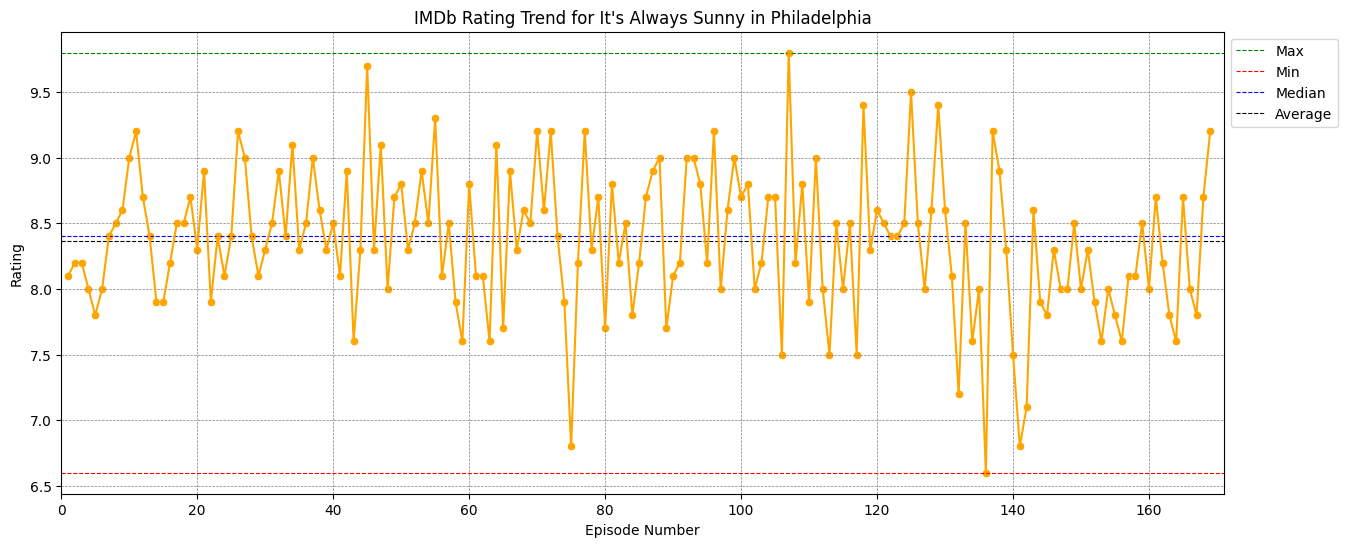

In [23]:
plt.figure(figsize=(15,6))
plt.grid(color='grey', linestyle='--', linewidth=0.5)

max_rating = show['rating_value'].max()
min_rating = show['rating_value'].min()

plt.axhline(max_rating, color='green', label='Max', linewidth=0.8, linestyle='--')
plt.axhline(min_rating, color='red', label='Min', linewidth=0.8, linestyle='--')
plt.axhline(show['rating_value'].median(), color='blue', label='Median', linewidth=0.8, linestyle='--')
plt.axhline(show['rating_value'].mean(), color='black', label='Average', linewidth=0.8, linestyle='--')
sns.lineplot(data=show, x='cumulative_episode_number', y='rating_value', color='orange')
sns.scatterplot(data=show, x='cumulative_episode_number', y='rating_value', color='orange')
plt.xlim(0,show['cumulative_episode_number'].max()+2)

plt.xlabel("Episode Number")
plt.ylabel("Rating")

plt.title(f"IMDb Rating Trend for {show_name}")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

print("Average: ", show['rating_value'].mean())
print("Max: ", max_rating, ", episode(s): ", show[show['rating_value'] == max_rating]['title'].tolist())
print("Min: ", min_rating, ", episode(s): ", show[show['rating_value'] == min_rating]['title'].tolist())
print("Median: ", show['rating_value'].median())

directory_path = f'data/{show_name}/figures'

# Create the directory if it does not exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

plt.savefig(f'data/{show_name}/figures/linegraph.png', dpi=300, bbox_inches='tight')

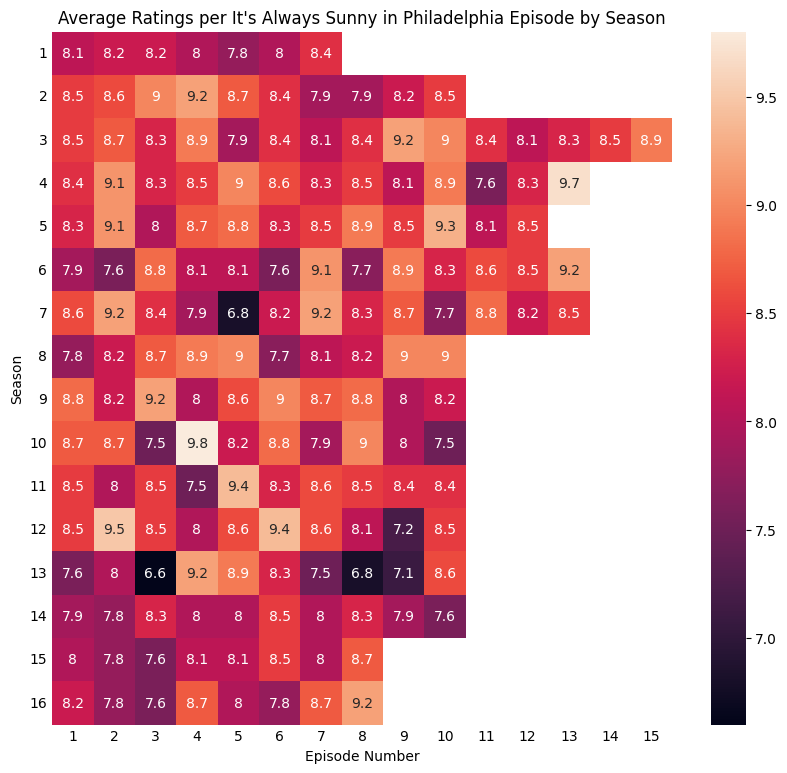

In [24]:
pivot_shows = show.pivot_table(index="season", columns="episode_number", values="rating_value")

plt.figure(figsize=(10,9))
ax = sns.heatmap(pivot_shows, annot=True)

ax.set_xlabel('Episode Number')
ax.set_ylabel('Season')

# Set the main title
ax.set_title(f'Average Ratings per {show_name} Episode by Season')

ax.tick_params(axis='both', which='both', length=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0) 
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

directory_path = f'data/{show_name}/figures'

# Create the directory if it does not exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

plt.savefig(f'data/{show_name}/figures/heatmap.png', dpi=300, bbox_inches='tight')

plt.show()

In [25]:
show.to_csv(f'data/{show_name}/{show_name}-imdbdata.csv')